In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1,l2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.image import resize
from rembg import remove
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate,Dropout, SpatialDropout2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Path where our data is located
base_path = "C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_train_processed/"

# Dictionary to save our 36 classes
categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"category": categories_list})
# df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
df

,category
0,25
1,4
2,26
3,4
4,32
...,...
35995,7
35996,11
35997,5
35998,7


In [3]:
# Image paths
train_dir = 'C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_train_processed'
test_dir = 'C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_test_processed'

# image dimensions and batch size
img_width, img_height = 200, 200
batch_size = 32
target_dimensions = (img_width, img_height, 3) ##64x64 RGB
# Function to create metadata
def create_metadata(data_dir):
    metadata = []
    for category in os.listdir(data_dir):
        category_dir = os.path.join(data_dir, category)
        category_images = os.listdir(category_dir)
        for filename in category_images:
            filepath = os.path.join(category_dir, filename)
            metadata.append({'filepath': filepath, 'label': category})
    return metadata

#metadata for train and test data
train_metadata = create_metadata(train_dir)
test_metadata = create_metadata(test_dir)

# Converting metadata to DataFrame
train_metadata_df = pd.DataFrame(train_metadata)
test_metadata_df = pd.DataFrame(test_metadata)

In [4]:
print(test_metadata_df)

                                                filepath label
0      C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     0
1      C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     0
2      C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     0
3      C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     0
4      C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     0
...                                                  ...   ...
14395  C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     Z
14396  C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     Z
14397  C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     Z
14398  C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     Z
14399  C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/...     Z

[14400 rows x 2 columns]


In [5]:
# Split dataset into training and test sets
train_data, val_data = train_test_split(train_metadata_df, test_size=0.2, random_state=42)

# Create data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255,              
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='filepath',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_metadata_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle= False,
    class_mode='categorical')

Found 28800 validated image filenames belonging to 36 classes.
Found 7200 validated image filenames belonging to 36 classes.
Found 14400 validated image filenames belonging to 36 classes.


In [6]:
classifier_vgg16 = VGG16(input_shape= target_dimensions ,include_top=False,weights='imagenet')

In [7]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [8]:
classifier1 = classifier_vgg16.output#head mode
classifier1 = SpatialDropout2D(0.5)(classifier1)
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)

classifier1 = Dense(36, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)

In [9]:
early_stoping = EarlyStopping(monitor='val_loss', 
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True, 
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
                                         patience = 2, 
                                         factor=0.5 , 
                                         verbose = 1)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [12]:
asl_class = model.fit(train_generator, 
                      validation_data= val_generator, 
                      epochs=10, 
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)

Epoch 1/10
900/900 [==============================] - 224s 242ms/step - loss: 1.0957 - accuracy: 0.6843 - val_loss: 0.3436 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 2/10
900/900 [==============================] - 208s 231ms/step - loss: 0.4508 - accuracy: 0.8595 - val_loss: 0.1920 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 3/10
900/900 [==============================] - 206s 228ms/step - loss: 0.3419 - accuracy: 0.8916 - val_loss: 0.1402 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 4/10
900/900 [==============================] - 199s 221ms/step - loss: 0.2915 - accuracy: 0.9067 - val_loss: 0.1227 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 5/10
900/900 [==============================] - 199s 221ms/step - loss: 0.2603 - accuracy: 0.9164 - val_loss: 0.1361 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 6/10
900/900 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.9169
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
900/900 [========================

In [13]:
# Evaluate for train generator
train_loss,train_acc = model.evaluate(train_generator , verbose = 0)

print('The accuracy of the model for training data is:',train_acc*100)
print('The Loss of the model for training data is:',train_loss)

The accuracy of the model for training data is: 99.15624856948853
The Loss of the model for training data is: 0.03205946087837219


In [14]:
# Evaluate for validation generator
val_loss,val_acc = model.evaluate(val_generator, verbose = 0)

print('The accuracy of the model for validation data is:',val_acc*100)
print('The Loss of the model for validation data is:',val_loss)

The accuracy of the model for validation data is: 98.50000143051147
The Loss of the model for validation data is: 0.05946473777294159


In [15]:
# Evaluvate for test generator
test_loss,test_acc = model.evaluate(test_generator, verbose = 0)

print('The accuracy of the model for validation data is:',test_acc*100)
print('The Loss of the model for validation data is:',test_loss)

The accuracy of the model for validation data is: 95.47222256660461
The Loss of the model for validation data is: 0.19210955500602722


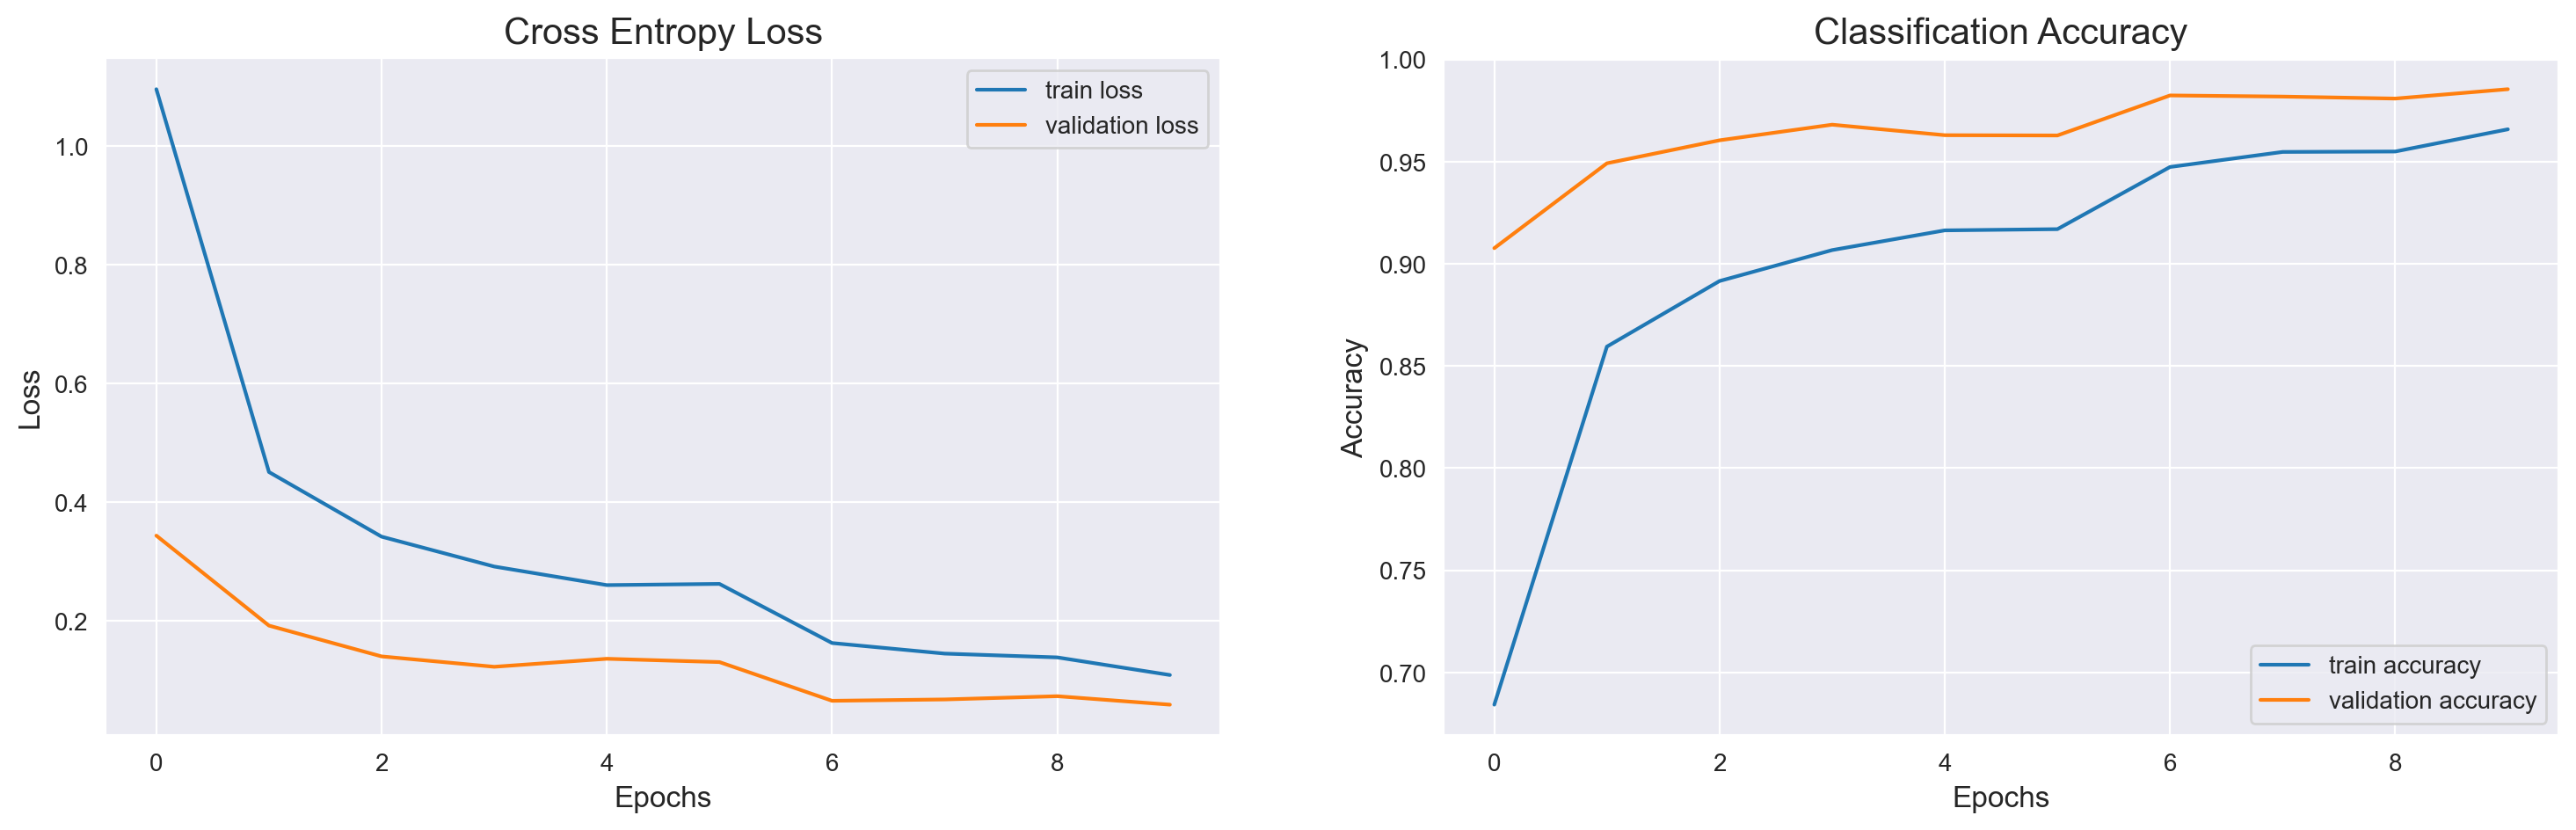

In [16]:
# plots for accuracy and Loss with epochs
error = pd.DataFrame(asl_class.history)
plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])
plt.legend(['train loss', 'validation loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])
plt.legend(['train accuracy', 'validation accuracy'])

plt.show()

In [17]:
# prediction
result = model.predict(test_generator,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 95.47222256660461
The Loss of the model for testing data is: 0.19210955500602722


In [18]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 13748
Incorrect predicted classes: 652


In [19]:
print(classification_report(y_true, y_pred,target_names= categories.values()))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       400
           1       0.87      0.99      0.93       400
           2       0.90      0.99      0.95       400
           3       0.99      0.98      0.99       400
           4       1.00      0.96      0.98       400
           5       0.97      0.99      0.98       400
           6       0.94      0.98      0.96       400
           7       0.98      0.96      0.97       400
           8       0.97      0.99      0.98       400
           9       1.00      0.98      0.99       400
           a       1.00      0.93      0.96       400
           b       0.96      0.99      0.98       400
           c       0.99      0.97      0.98       400
           d       0.98      0.93      0.96       400
           e       0.78      0.91      0.84       400
           f       0.99      0.94      0.97       400
           g       0.99      0.98      0.99       400
           h       0.96    

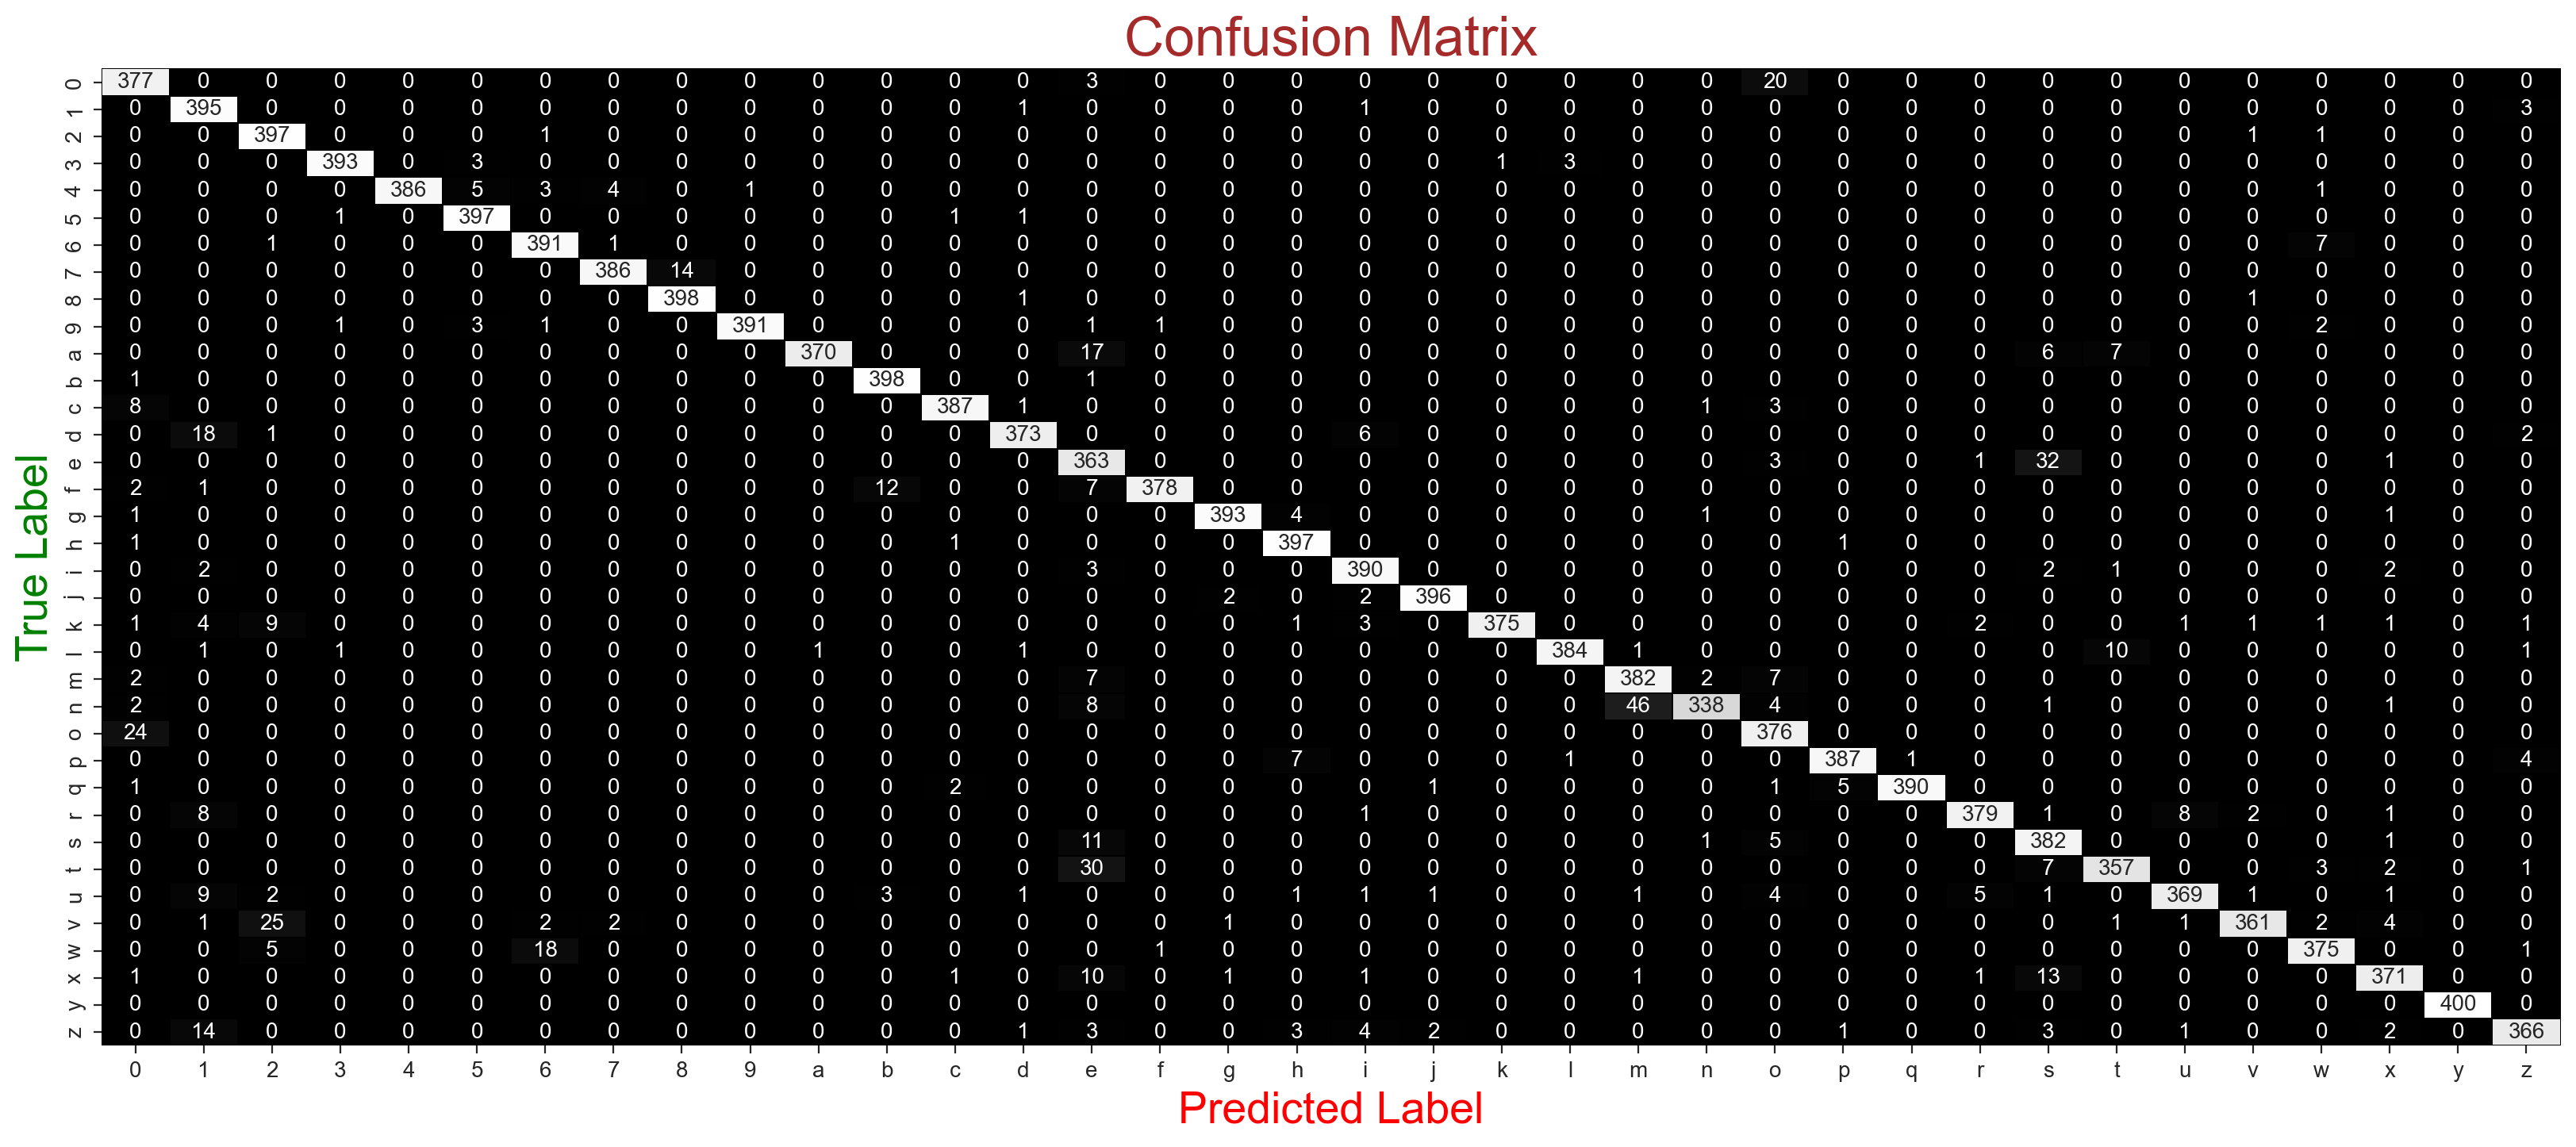

In [20]:
sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_true,y_pred) 

f,ax = plt.subplots(figsize = (20,8),dpi=200)

sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.1, cmap = "gist_yarg_r", 
            linecolor="black", fmt='.0f', ax=ax, 
            cbar=False, xticklabels=categories.values(), 
            yticklabels=categories.values())

plt.xlabel("Predicted Label",fontdict={'color':'red','size':20})
plt.ylabel("True Label",fontdict={'color':'green','size':20})
plt.title("Confusion Matrix",fontdict={'color':'brown','size':25})

plt.show()

In [21]:
# Saving the model of vgg16
model.save('ASL_VGG16_model.h5')

In [22]:
#Load the Custom CNN model 
model = load_model("ASL_VGG16_model.h5")

In [23]:
def remove_background(input_path, output_path):
    input_image = Image.open(input_path)
    # Assuming `remove` function removes the background and returns an RGBA image
    # You can convert it to RGB mode before saving
    output_image = remove(input_image)
    # Convert RGBA image to RGB mode
    output_image = output_image.convert("RGB")
    output_image.save(output_path)
    return output_image

def predict_class(model,img_path):
        
        img_no_bg_path = "temp_no_bg.jpg"  # Temporary file to store the image without background
        remove_background(img_path, img_no_bg_path)

        # Load and preprocess the image
        img_width, img_height = 200, 200
        image_no_bg = image.load_img( img_no_bg_path, target_size=(img_width, img_height))
        img_array = image.img_to_array(image_no_bg)

        img_array /= 255.0
        # Resize the image to match the model's input shape
        img_array_resized = resize(img_array, (img_width, img_height))


        # Expand dimensions to create a batch with a single image
        img_array_resized = np.expand_dims(img_array_resized, axis=0)

        # Make predictions
        predictions = model.predict(img_array_resized)

        # Print predicted class index
        predicted_class_index = np.argmax(predictions)
        print("Predicted class index:", predicted_class_index)
        return predicted_class_index

In [24]:
img_path1='C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_test_processed/M/M61.jpg'
img_path2='C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_train_processed/B/B1284.jpg'
img_path3='C:/Users/ANBU NAMBI/Desktop/CSCI 6364/Project/Datasets/ASL_Data_Preprocessed/asl_data_test_processed/5/5 (10).jpg'
# model="ASL_Custom_model2.h5"
img_paths=[img_path1,img_path2,img_path3]

for img in img_paths:
    index= predict_class(model,img)
    print("Predicted sign:",categories[index])

1/1 [==============================] - 1s 1s/step
Predicted class index: 22
Predicted sign: m
1/1 [==============================] - 0s 21ms/step
Predicted class index: 11
Predicted sign: b
1/1 [==============================] - 0s 20ms/step
Predicted class index: 5
Predicted sign: 5


In [25]:
input_img = r"C:\Users\ANBU NAMBI\Desktop\CSCI 6364\Project\input_images\input_images\working\four.jpg"
index= predict_class(model,input_img)
print("Predicted sign:",categories[index])

1/1 [==============================] - 0s 20ms/step
Predicted class index: 4
Predicted sign: 4
